# Anomaly Detection fake access point

**Objectives**: implement Gaussian distribution model to detect rogue access points. 

In [1]:
# Loading relevant libraries and the dataset
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Load Data 

In [2]:
normal_beacons = np.loadtxt("home_beacons_obs_features.dat", delimiter=" ", skiprows=1)
abnormal_beacons = np.loadtxt("other_home_beacons_obs_features.dat", delimiter=" ", skiprows=1)

print(f"Total normal beacons examples: {len(normal_beacons)}")
print(f"Total abnormal beacons examples: {len(abnormal_beacons)}")

normal_assoc = np.loadtxt("home_association.csv", delimiter=",", skiprows=1)
abnormal_assoc = np.loadtxt("other_home_association.csv", delimiter=",", skiprows=1)

print(f"\nTotal normal associations examples: {len(normal_assoc)}")
print(f"Total abnormal associations examples: {len(abnormal_assoc)}")

#temp solution replicate home associations
normal_assoc = np.vstack((normal_assoc, normal_assoc))

#under sample so that number of beacons examples = number of association examples
n_samples = min(normal_beacons.shape[0], normal_assoc.shape[0])
normal_ap = np.hstack((normal_beacons[0:n_samples,:], normal_assoc[0:n_samples,:]))
print(normal_ap.shape)

n_samples = min(abnormal_beacons.shape[0], abnormal_assoc.shape[0])
abnormal_ap = np.hstack((abnormal_beacons[0:n_samples,:], abnormal_assoc[0:n_samples,:]))
print(abnormal_ap.shape)

n_features = normal_ap.shape[1]


Total normal beacons examples: 197
Total abnormal beacons examples: 101

Total normal associations examples: 98
Total abnormal associations examples: 151
(196, 9)
(101, 9)


### Transform data


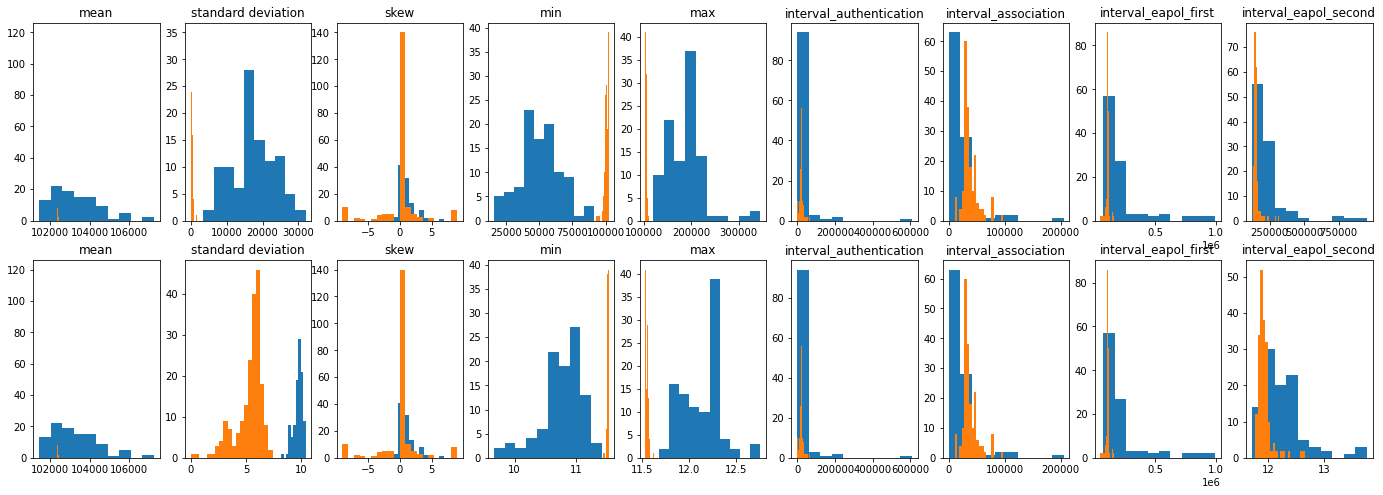

In [3]:
plt.figure(figsize=(24, 8))

transform_features = (1, 3, 4, 8)

trans_normal_ap = np.copy(normal_ap)
for i in transform_features:
    trans_normal_ap[:,i] = np.log(normal_ap[:,i])

trans_normal_ap[np.isinf(trans_normal_ap)] = 0

trans_abnormal_ap = np.copy(abnormal_ap)
for i in transform_features:
    trans_abnormal_ap[:,i] = np.log(abnormal_ap[:,i])
trans_abnormal_ap[np.isinf(trans_abnormal_ap)] = 0

features = ("mean", "standard deviation", "skew", "min", "max", #beacons features
            "interval_authentication", "interval_association", "interval_eapol_first", "interval_eapol_second") #association features
for i in range (0, n_features):
    plt.subplot(2, n_features, i + 1)
    plt.hist(abnormal_ap[:, i])
    plt.hist(normal_ap[:, i], 20)
    plt.title(features[i])
    

for i in range(0, n_features):
    plt.subplot(2, n_features, n_features + i + 1)
    plt.hist(trans_abnormal_ap[:, i])
    plt.hist(trans_normal_ap[:, i], 20)
    plt.title(features[i])


#delete unused features
delete_features = (1,3,4)
trans_normal_ap = np.delete(trans_normal_ap, delete_features, 1)
trans_abnormal_ap = np.delete(trans_abnormal_ap, delete_features, 1)

n_features = n_features - len(delete_features)


### Build sets

In [4]:
#train set 60 % normal
#validation set 20 % normal, 20 % abnormal
#test set 20 % normal, 20 % abnormal
total_normal_train = int(len(trans_normal_ap) * 0.60)
total_normal_val = int(len(trans_normal_ap) * 0.20)
total_normal_test = int(len(trans_normal_ap) * 0.20)

total_abnormal_val = int(len(trans_abnormal_ap) * 0.20) 
total_abnormal_test = int(len(trans_abnormal_ap) * 0.20) 

total_train = total_normal_train
total_val = total_normal_val + total_abnormal_val
total_test = total_normal_test + total_abnormal_test

print(f"Training set\n Total examples: {total_train}\n Total normal: {total_normal_train}")
print(f"Valadition set\n Total examples: {total_val}\n Total normal: {total_normal_val}\n Total abnormal: {total_abnormal_val}")
print(f"Test set\n Total examples: {total_val}\n Total normal: {total_normal_test}\n Total abnormal: {total_abnormal_test}")

#Train set
idx = np.random.choice(len(trans_normal_ap), size=total_normal_train, replace = False)
x_train = trans_normal_ap[idx, :]
#remove used examples
trans_normal_ap = np.delete(trans_normal_ap, idx, axis=0)

print(f"Train set: {x_train.shape}")

#validation set
idx = np.random.choice(len(trans_normal_ap), size=total_normal_val, replace = False)
x_val = trans_normal_ap[idx, :]
#remove used examples
trans_normal_ap = np.delete(trans_normal_ap, idx, axis=0)

idx = np.random.choice(len(trans_abnormal_ap), size=total_abnormal_val, replace = False)
x_val = np.vstack((x_val, trans_abnormal_ap[idx, :]))
#remove used examples
trans_abnormal_ap = np.delete(trans_abnormal_ap, idx, axis=0)

y_val = np.zeros((total_normal_val, 1))
y_val = np.vstack((y_val, np.ones((total_abnormal_val, 1))))

print(f"Validation set: {x_val.shape}")


#Test set
idx = np.random.choice(len(trans_normal_ap), size=total_normal_test, replace = False)
x_test = trans_normal_ap[idx, :]

idx = np.random.choice(len(trans_abnormal_ap), size=total_abnormal_test, replace = False)
x_test = np.vstack((x_test, trans_abnormal_ap[idx, :]))

y_test = np.zeros((total_normal_test, 1))
y_test = np.vstack((y_test, np.ones((total_abnormal_test, 1))))

print(f"Test set: {x_test.shape}")

Training set
 Total examples: 117
 Total normal: 117
Valadition set
 Total examples: 59
 Total normal: 39
 Total abnormal: 20
Test set
 Total examples: 59
 Total normal: 39
 Total abnormal: 20
Train set: (117, 6)
Validation set: (59, 6)
Test set: (59, 6)


### Plot data

Plot the scater plots of the data subsets (Xtrain,Xval, Xtest) and get figure similar to Fig. 1. 

<img src="images/im1.png" style="width:600px;height:300px;">
<caption><center> **Fig. 1** : **Latency versus Throughput** </center></caption>

(0.0, 10.0)

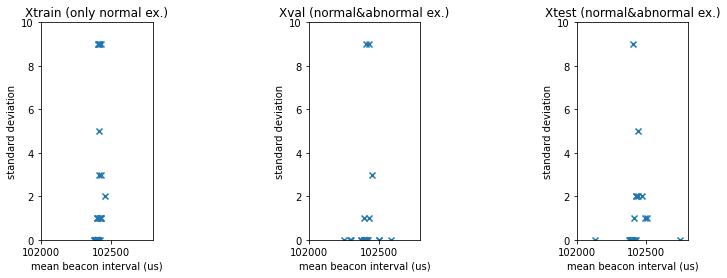

In [5]:
plt.figure(figsize=(14,4))

plt.subplot(1, 6, 1)
plt.scatter(x_train[:,0], x_train[:,1], marker="x")
plt.xlabel("mean beacon interval (us)")
plt.ylabel("standard deviation")
plt.title("Xtrain (only normal ex.)")
plt.xlim(102000, 102800)
plt.ylim(0, 10)

plt.subplot(1, 6, 3)
plt.scatter(x_val[:,0], x_val[:,1], marker="x")
plt.xlabel("mean beacon interval (us)")
plt.ylabel("standard deviation")
plt.title("Xval (normal&abnormal ex.)")
plt.xlim(102000, 102800)
plt.ylim(0, 10)

plt.subplot(1, 6, 5)
plt.scatter(x_test[:,0], x_test[:,1], marker="x")
plt.xlabel("mean beacon interval (us)")
plt.ylabel("standard deviation")
plt.title("Xtest (normal&abnormal ex.)")
plt.xlim(102000, 102800)
plt.ylim(0, 10)

### Plot Data

Plot the histograms of each feature and get figure simular to Fig.2. 


<img src="images/im2.png" style="width:300px;height:250px;">
<caption><center> **Fig. 1** : **Data distribution** </center></caption>

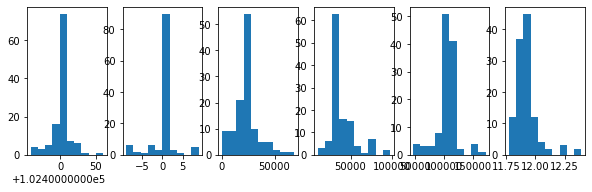

In [6]:
plt.figure(figsize=(10, 6))

for i in range (0, n_features):
    plt.subplot(2, n_features, i + 1)
    plt.hist(x_train[:, i])


### Gaussian Distribution

To perform anomaly detection, you will first need to fit a model only to the normal data.

Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each of the features. For each feature (i = 1 . . . n), you need to find parameters mean and variance(mu, sigma²). For doing that let’s write down the function that calculates the mean and variance of matrix Xtrain.

The Gaussian distribution is given by:  $p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$

mean:  $\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$

variance:  $\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [7]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m = X.shape[0]  #number of examples in X
    
    #compute mean 
    mu = np.mean(X, axis=0)
     
    # compute variance =sigma^2
    sigma2 = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,sigma2

In [8]:
# Estimate parameters (mean and variance) for the Gaussian model of the normal data (Xtrain)
# ANSWER:    mu =  [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]

mu, sigma2 = estimateGaussian(x_train)
print(f"mu = {mu} ; sigma2 = {sigma2}")



mu = [ 1.02399957e+05 -2.13675214e-01  2.35247204e+04  3.89069777e+04
  1.06464635e+05  1.19263061e+01] ; sigma2 = [1.75647746e+02 9.29622324e+00 1.27614454e+08 2.42378195e+08
 3.18411386e+08 1.04762569e-02]


### Multivariate Gaussian Distribution

Inside *multivariateGaussian*, $\sigma^2$ vector is converted into the covariance matrix  $\Sigma$.  Assuming the features are independent, each element of vector $\sigma^2$ will be on the diagonal of matrix $\Sigma$ and the rest of the elements are zero. 
Then the formula for the multivariate distribution to get the probability vector is applied.

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [9]:
#Complete the function
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n= len(mu) #number of features 
    sigma_diag=np.diag(sigma2)  #Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

### Select the threshold $\epsilon$  that will flag an example as anomaly

F1 score is used to determine the best parameters i.e best epsilon and best F1 instead of accuracy as the dataset is highly unbalanced. F1 score takes into consideration precision and recall.

Precision = true positive/(true positive + false positive)

Recall = true positive /(true positive + false negative)

F1=2(Recall * Precision) / (Recall + Precision)

Best parameters are the ones in which the F1 score value is maximum.

Predict anomaly if pval<epsilon that gives a vector of binary values in the variable predictions.

Note: We need a try-except block because there can be cases where we divide by zero to calculate precision and recall.

In [10]:
from sklearn.metrics import confusion_matrix

#Complete the function
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    best_epi = 0
    best_F1 = 0
    best_tn = 0
    best_fp = 0
    best_fn = 0
    best_tp = 0

    #range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis]
        #compute true positive (TP)
        #tp = np.sum(predictions[yval==1]==1)

        #compute true negative (TN)
        #tn = np.sum(predictions[yval==0]==0)
        
        #compute false positive (FP)
        #fp = np.sum(predictions[yval==0]==1)
        
        #compute false negative 
        #fn = np.sum(predictions[yval==1]==0)      
        
        tn, fp, fn, tp = confusion_matrix(yval, predictions).ravel()
        
        try:
        # compute precision, recall and F1
            prec = tp/(tp+fp)
            
            #compute recall and F1
            rec = tp/(tp+fn)

            #compute  F1
            F1 = (2*prec*rec)/(prec+rec) 
        
            if F1 > best_F1:
                best_F1 = F1
                best_epi = epi
                best_tn = tn
                best_fp = fp
                best_fn = fn
                best_tp = tp
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1, best_tn, best_fp, best_fn, best_tp

In [11]:
#Apply multivariateGaussian to compute the probability of the examples in Xval. 
pval = multivariateGaussian(x_val, mu, sigma2)

#Apply selectThreshold to compute the best epsilon and best F1 with the validation data
epsilon, F1, tn, fp, fn, tp = selectThreshold(y_val, pval)

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")

print("Best epsilon found using cross-validation:",epsilon)  #ANSWER: 0.00018
print("Best F1 on Cross Validation Set:",F1)  #ANSWER: 0.8235


True positives: 20
False positives: 4
True negatives: 35
False negatives: 0
Best epsilon found using cross-validation: 2.9051160954358214e-19
Best F1 on Cross Validation Set: 0.9090909090909091


We need to return the indices of the outliers to identify the faulty servers. This gives us a vector with binary entries where 1 means anomaly and 0 means normal.

In [18]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [19]:
#Apply multivariateGaussian to detect abnormal examples (outliers) 
p = multivariateGaussian(x_test, mu, sigma2)

outl = (p < epsilon)
listOfOutliers=findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers (Xtest):', count_outliers)  #ANSWER: 6 
print('\n',listOfOutliers)




Number of outliers (Xtest): 32

 [1, 2, 7, 9, 10, 13, 16, 22, 25, 27, 31, 32, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


### Visualize the anomalies

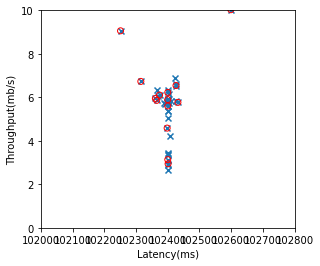

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x_test[:, 0], x_test[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(x_test[listOfOutliers,0], x_test[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.xlim(102000, 102800)
plt.ylim(0, 10)
plt.show()